In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import gzip
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from scipy.stats import pearsonr, spearmanr
import sys

In [2]:
def load_experiment_data(instance_path):
    dfs = {
        "pathways": None,
        "statistics": None,
        "train_stats": None,
        "test_stats": None, 
        "val_stats": None
    }

    if not os.path.isdir(instance_path):
        print(f"Error: Directory not found at {instance_path}")
        return tuple(dfs.values())

    for filename in os.listdir(instance_path):
        file_path = os.path.join(instance_path, filename)
        
        # Skip if not a file
        if not os.path.isfile(file_path):
            continue

        try:
            if 'analysis' in filename and filename.endswith('.json.gz'):
                print(f"Attempting to load {filename} (analysis JSON)...")
                with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                    data = json.load(f)
                dfs['drgp'] = pd.DataFrame(data) 
                print(f"Successfully created DataFrame for {filename}")
            elif 'results' in filename and filename.endswith('.pkl'):
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)
                if isinstance(data, dict):
                    dfs['statistics'] = pd.DataFrame([data])
                elif isinstance(data, list): 
                    dfs['statistics'] = pd.DataFrame(data)
                else:
                    print(f"Warning: statistics file {filename} has an unexpected main data type: {type(data)}. Could not convert to DataFrame.")
                
            elif 'train' in filename and filename.endswith('.csv.gz'):
                dfs['train_stats'] = pd.read_csv(file_path, compression='gzip')
            elif 'test' in filename and filename.endswith('.csv.gz'):
                dfs['test_stats'] = pd.read_csv(file_path, compression='gzip')
            elif 'val' in filename and filename.endswith('.csv.gz'):
                dfs['val_stats'] = pd.read_csv(file_path, compression='gzip')
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    return dfs['pathways'], dfs['statistics'], dfs['train_stats'], dfs['test_stats'], dfs['val_stats']

In [3]:
def analyze_statistics(statistics_df):
    row_data = statistics_df.iloc[0]
    train_metrics=row_data['train_metrics']
    test_metrics=row_data['test_metrics']
    val_metrics=row_data['val_metrics']

    metrics_list = [
        {'set': 'train', 'metrics': train_metrics},
        {'set': 'validation', 'metrics': val_metrics},
        {'set': 'test', 'metrics': test_metrics}
    ]
    
    metrics_df = pd.DataFrame([
        {'Set': 'Train', **train_metrics},
        {'Set': 'Validation', **val_metrics},
        {'Set': 'Test', **test_metrics}
    ])

    print("Metrics Summary Table:")
    print("=" * 80)
    print(metrics_df.to_string(index=False, float_format='%.4f'))
    print("=" * 80)

    print(f"\nAvailable metrics: {list(train_metrics.keys())}")
    
    return metrics_list, metrics_df

In [4]:
combined_path="/labs/Aguiar/SSPA_BRAY/BRay/Gibbs/minimal_test_results"

runs_accuracy = [] 

# Loop through each folder in the combined_path directory
for folder in os.listdir(combined_path):
    folder_path = os.path.join(combined_path, folder)
    if os.path.isdir(folder_path):
        # Process files within the folder using the already defined function
        _, statistics_df, _, _, _ = load_experiment_data(folder_path)
        if statistics_df is not None:
            # Analyze the statistics dataframe to get metric summaries
            _, metrics_df = analyze_statistics(statistics_df)
            # Check if accuracy is one of the available metrics
            if 'accuracy' in metrics_df.columns:
                for _, row in metrics_df.iterrows():
                    runs_accuracy.append({
                        'Run': folder,
                        'Set': row['Set'],
                        'Accuracy': row['accuracy']
                    })
            else:
                print(f"Run {folder} does not report an accuracy metric.")
        else:
            print(f"Run {folder} did not have statistics data available.")

# Create a combined dataframe with the accuracy for all runs
df_accuracy = pd.DataFrame(runs_accuracy)
print("\nAggregated Accuracy Table:")
print(df_accuracy.to_string(index=False))


Aggregated Accuracy Table:
Empty DataFrame
Columns: []
Index: []


In [5]:
# Sort df_accuracy by validation set accuracy in descending order
df_accuracy_sorted = df_accuracy[df_accuracy['Set'] == 'Validation'].sort_values('Accuracy', ascending=False)

print("Validation Accuracy Rankings (Highest to Lowest):")
print("=" * 60)
print(df_accuracy_sorted.to_string(index=False))

# Find the run with highest validation accuracy
best_run = df_accuracy_sorted.iloc[0]['Run']
best_val_accuracy = df_accuracy_sorted.iloc[0]['Accuracy']

print(f"\nBest performing run: {best_run}")
print(f"Highest validation accuracy: {best_val_accuracy:.4f}")

# Show all metrics for the best run
best_run_metrics = df_accuracy[df_accuracy['Run'] == best_run]
print(f"\nComplete metrics for best run ({best_run}):")
print(best_run_metrics.to_string(index=False))

Validation Accuracy Rankings (Highest to Lowest):
            Run        Set  Accuracy
20250522_191455 Validation    0.8800
20250522_201734 Validation    0.8625
20250523_052630 Validation    0.8600
20250523_012226 Validation    0.8575
20250522_150830 Validation    0.8550
20250523_103416 Validation    0.8500
20250523_002113 Validation    0.8500
20250522_160951 Validation    0.8475
20250523_093049 Validation    0.8475
20250522_211910 Validation    0.8475
20250523_022506 Validation    0.8425
20250522_232131 Validation    0.8350
20250523_062743 Validation    0.8325
20250523_083114 Validation    0.8325
20250523_042358 Validation    0.8300
20250523_032442 Validation    0.8275
20250522_181459 Validation    0.8225
20250523_072712 Validation    0.8225
20250522_171217 Validation    0.8200
20250522_221841 Validation    0.8075

Best performing run: 20250522_191455
Highest validation accuracy: 0.8800

Complete metrics for best run (20250522_191455):
            Run        Set  Accuracy
20250522_191

In [5]:
best_exp = "/labs/Aguiar/SSPA_BRAY/BRay/Gibbs/minimal_test_results"


In [6]:
best_pathways, best_statistics, best_train_stats, best_test_stats, best_val_stats = load_experiment_data(best_exp)

In [7]:
best_train_stats

,true_label_0,true_label_1,predicted_label_0,predicted_label_1,predicted_probability_0,predicted_probability_1
0,1,0,0,0,0.417179,0.208031
1,0,1,0,0,0.298431,0.277939
2,0,1,0,1,0.268683,1.000000
3,0,0,0,0,0.340874,0.322188
4,1,0,0,0,0.308757,0.008497
5,1,0,0,0,0.477480,0.256901
6,0,0,1,0,0.556593,0.320850
7,1,0,0,0,0.251344,0.159652
8,0,0,0,0,0.313994,0.302082
9,0,0,0,0,0.259195,0.236077


In [8]:
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc

# Create interactive plots for model evaluation
import plotly.graph_objects as go
import plotly.express as px

# Combine all datasets for comprehensive analysis
datasets = {
    'Train': best_train_stats,
    'Validation': best_val_stats, 
    'Test': best_test_stats
}

# 1. ROC Curve Plot
fig_roc = go.Figure()

for name, df in datasets.items():
    fpr, tpr, _ = roc_curve(df['true_label'], df['probability'])
    roc_auc = auc(fpr, tpr)
    
    fig_roc.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f'{name} (AUC = {roc_auc:.3f})',
        line=dict(width=2)
    ))

# Add diagonal line
fig_roc.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    name='Random Classifier',
    line=dict(dash='dash', color='gray')
))

fig_roc.update_layout(
    title='ROC Curves for All Datasets',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=600, height=500
)

fig_roc.show()

# 2. Confusion Matrix Plots
fig_cm = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Train', 'Validation', 'Test'],
    specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]]
)

for i, (name, df) in enumerate(datasets.items(), 1):
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    
    fig_cm.add_trace(
        go.Heatmap(
            z=cm,
            x=['Predicted 0', 'Predicted 1'],
            y=['True 0', 'True 1'],
            colorscale='Blues',
            showscale=(i==1),
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 14}
        ),
        row=1, col=i
    )

fig_cm.update_layout(
    title='Confusion Matrices',
    width=900, height=350
)

fig_cm.show()

# 3. Probability Distribution Plots
fig_dist = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Train', 'Validation', 'Test']
)

for i, (name, df) in enumerate(datasets.items(), 1):
    # Separate probabilities by true label
    prob_0 = df[df['true_label'] == 0]['probability']
    prob_1 = df[df['true_label'] == 1]['probability']
    
    fig_dist.add_trace(
        go.Histogram(
            x=prob_0,
            name=f'{name} - True Label 0',
            opacity=0.7,
            nbinsx=30,
            legendgroup=f'group{i}'
        ),
        row=1, col=i
    )
    
    fig_dist.add_trace(
        go.Histogram(
            x=prob_1,
            name=f'{name} - True Label 1',
            opacity=0.7,
            nbinsx=30,
            legendgroup=f'group{i}'
        ),
        row=1, col=i
    )

fig_dist.update_layout(
    title='Probability Distributions by True Label',
    width=1200, height=400,
    barmode='overlay'
)

fig_dist.update_xaxes(title_text="Predicted Probability")
fig_dist.update_yaxes(title_text="Count")

fig_dist.show()

# 4. Performance Metrics Summary
metrics_summary = []
for name, df in datasets.items():
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    fpr, tpr, _ = roc_curve(df['true_label'], df['probability'])
    roc_auc = auc(fpr, tpr)
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_summary.append({
        'Dataset': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    })

metrics_df_detailed = pd.DataFrame(metrics_summary)

# Interactive metrics table
fig_metrics = go.Figure(data=[go.Table(
    header=dict(values=list(metrics_df_detailed.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[metrics_df_detailed[col] for col in metrics_df_detailed.columns],
               fill_color='lavender',
               align='left',
               format=[None, '.4f', '.4f', '.4f', '.4f', '.4f', None, None, None, None]))
])

fig_metrics.update_layout(title="Detailed Performance Metrics", width=800, height=300)
fig_metrics.show()

print("Interactive plots created successfully!")
print("\nDetailed Metrics Summary:")
print(metrics_df_detailed.round(4))

KeyError: 'true_label'

In [9]:
best_pathways

In [10]:
# Extract pathway names and upsilon values from best_pathways
pathway_upsilon_data = []

for pathway_name, row in best_pathways.iterrows():
    pathway_info = row['pathways']
    upsilon_value = pathway_info['upsilon']
    
    pathway_upsilon_data.append({
        'pathway_name': pathway_name,
        'upsilon': upsilon_value
    })

# Create DataFrame and sort by upsilon values (descending)
pathway_upsilon_df = pd.DataFrame(pathway_upsilon_data)
pathway_upsilon_df_sorted = pathway_upsilon_df.sort_values('upsilon', ascending=False)

print("Top 20 Pathways/Gene Programs by Upsilon Value:")
print("=" * 80)
print(pathway_upsilon_df_sorted.head(20).to_string(index=False))

print("\nBottom 20 Pathways/Gene Programs by Upsilon Value:")
print("=" * 80)
print(pathway_upsilon_df_sorted.tail(20).to_string(index=False))

# Save the sorted list for later use
pathways_sorted_by_upsilon = pathway_upsilon_df_sorted.to_dict('records')

print(f"\nTotal pathways/gene programs: {len(pathways_sorted_by_upsilon)}")
print(f"Upsilon range: {pathway_upsilon_df_sorted['upsilon'].min():.4f} to {pathway_upsilon_df_sorted['upsilon'].max():.4f}")

AttributeError: 'NoneType' object has no attribute 'iterrows'

In [ ]:
ajm_cyto_samples

View of AnnData object with n_obs × n_vars = 2666 × 57010
    obs: 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim', 'ap', 'cyto', 'ig', 'dataset'
    var: 'gene_symbols'

In [13]:
from plotly.subplots import make_subplots

# Create interactive plot for top and bottom pathways/gene programs by upsilon values
import plotly.graph_objects as go

# Get top 20 and bottom 20 pathways
top_20 = pathway_upsilon_df_sorted.head(20)
bottom_20 = pathway_upsilon_df_sorted.tail(20)

# Create subplot with two bar charts
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Top 20 Pathways/Gene Programs (Highest Upsilon)', 
                   'Bottom 20 Pathways/Gene Programs (Lowest Upsilon)'),
    vertical_spacing=0.15
)

# Top 20 pathways (positive influence)
fig.add_trace(
    go.Bar(
        x=top_20['upsilon'],
        y=top_20['pathway_name'],
        orientation='h',
        name='Top 20',
        marker=dict(color='darkgreen', opacity=0.8),
        text=[f'{val:.3f}' for val in top_20['upsilon']],
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>Upsilon: %{x:.4f}<extra></extra>'
    ),
    row=1, col=1
)

# Bottom 20 pathways (negative influence)  
fig.add_trace(
    go.Bar(
        x=bottom_20['upsilon'],
        y=bottom_20['pathway_name'],
        orientation='h',
        name='Bottom 20',
        marker=dict(color='darkred', opacity=0.8),
        text=[f'{val:.3f}' for val in bottom_20['upsilon']],
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>Upsilon: %{x:.4f}<extra></extra>'
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    title=dict(
        text='Pathway/Gene Program Upsilon Values: Top 20 vs Bottom 20',
        font=dict(size=16)
    ),
    height=1000,
    width=1200,
    showlegend=False,
    font=dict(size=10)
)

# Update x-axes
fig.update_xaxes(title_text="Upsilon Value", row=1, col=1)
fig.update_xaxes(title_text="Upsilon Value", row=2, col=1)

# Update y-axes to reverse order for better readability
fig.update_yaxes(autorange="reversed", row=1, col=1)
fig.update_yaxes(autorange="reversed", row=2, col=1)

# Add vertical line at x=0 for reference
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5, row=1, col=1)
fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5, row=2, col=1)

fig.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Highest upsilon value: {top_20.iloc[0]['upsilon']:.4f} ({top_20.iloc[0]['pathway_name']})")
print(f"Lowest upsilon value: {bottom_20.iloc[-1]['upsilon']:.4f} ({bottom_20.iloc[-1]['pathway_name']})")
print(f"Range: {top_20.iloc[0]['upsilon'] - bottom_20.iloc[-1]['upsilon']:.4f}")

Summary Statistics:
Highest upsilon value: 0.9885 (REACTOME_MOLYBDENUM_COFACTOR_BIOSYNTHESIS)
Lowest upsilon value: -0.9879 (REACTOME_SMAD2_SMAD3_SMAD4_HETEROTRIMER_REGULATES_TRANSCRIPTION)
Range: 1.9764


In [15]:
# Calculate absolute values and sort by absolute upsilon values
pathway_upsilon_df['abs_upsilon'] = pathway_upsilon_df['upsilon'].abs()
pathway_upsilon_df_abs_sorted = pathway_upsilon_df.sort_values('abs_upsilon', ascending=False)

# Function to create plots for different top N values
def create_top_pathways_plot(n_top=50):
    # Get top N pathways by absolute upsilon value
    top_n = pathway_upsilon_df_abs_sorted.head(n_top)
    
    # Separate positive and negative upsilon values
    positive_mask = top_n['upsilon'] > 0
    negative_mask = top_n['upsilon'] < 0
    
    pos_count = positive_mask.sum()
    neg_count = negative_mask.sum()
    
    # Create the plot
    fig = go.Figure()
    
    # Add positive upsilon values (green)
    if pos_count > 0:
        fig.add_trace(
            go.Bar(
                x=top_n[positive_mask]['upsilon'],
                y=top_n[positive_mask]['pathway_name'],
                orientation='h',
                name=f'Positive ({pos_count})',
                marker=dict(color='darkgreen', opacity=0.8),
                text=[f'{val:.3f}' for val in top_n[positive_mask]['upsilon']],
                textposition='outside',
                hovertemplate='<b>%{y}</b><br>Upsilon: %{x:.4f}<extra></extra>'
            )
        )
    
    # Add negative upsilon values (red)
    if neg_count > 0:
        fig.add_trace(
            go.Bar(
                x=top_n[negative_mask]['upsilon'],
                y=top_n[negative_mask]['pathway_name'],
                orientation='h',
                name=f'Negative ({neg_count})',
                marker=dict(color='darkred', opacity=0.8),
                text=[f'{val:.3f}' for val in top_n[negative_mask]['upsilon']],
                textposition='outside',
                hovertemplate='<b>%{y}</b><br>Upsilon: %{x:.4f}<extra></extra>'
            )
        )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f'Top {n_top} Pathways/Gene Programs by Absolute Upsilon Value',
            font=dict(size=16)
        ),
        height=max(600, n_top * 15),  # Adjust height based on number of pathways
        width=1200,
        xaxis_title="Upsilon Value",
        yaxis=dict(autorange="reversed"),  # Top pathway at top
        showlegend=True,
        font=dict(size=10)
    )
    
    # Add vertical line at x=0 for reference
    fig.add_vline(x=0, line_dash="dash", line_color="gray", opacity=0.5)
    
    return fig

# Create plots for top 20, 50, and 100 pathways
fig_top_20 = create_top_pathways_plot(20)
fig_top_50 = create_top_pathways_plot(50)
fig_top_100 = create_top_pathways_plot(100)

# Show the plots
print("Top 20 Pathways by Absolute Upsilon Value:")
fig_top_20.show()

print("\nTop 50 Pathways by Absolute Upsilon Value:")
fig_top_50.show()

print("\nTop 100 Pathways by Absolute Upsilon Value:")
fig_top_100.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Total pathways: {len(pathway_upsilon_df_abs_sorted)}")
print(f"Range of absolute upsilon values: {pathway_upsilon_df_abs_sorted['abs_upsilon'].min():.4f} to {pathway_upsilon_df_abs_sorted['abs_upsilon'].max():.4f}")

# Show top 20 table
top_20 = pathway_upsilon_df_abs_sorted.head(20)
print(f"\nTop 20 Pathways by Absolute Upsilon Value:")
print("=" * 100)
print(top_20[['pathway_name', 'upsilon', 'abs_upsilon']].to_string(index=False))

Top 20 Pathways by Absolute Upsilon Value:



Top 50 Pathways by Absolute Upsilon Value:



Top 100 Pathways by Absolute Upsilon Value:



Summary Statistics:
Total pathways: 1772
Range of absolute upsilon values: 0.0000 to 0.9885

Top 20 Pathways by Absolute Upsilon Value:
                                                                          pathway_name   upsilon  abs_upsilon
                                             REACTOME_MOLYBDENUM_COFACTOR_BIOSYNTHESIS  0.988525     0.988525
                       REACTOME_SMAD2_SMAD3_SMAD4_HETEROTRIMER_REGULATES_TRANSCRIPTION -0.987915     0.987915
                   REACTOME_TRANSCRIPTIONAL_ACTIVITY_OF_SMAD2_SMAD3_SMAD4_HETEROTRIMER -0.851959     0.851959
REACTOME_DEX_H_BOX_HELICASES_ACTIVATE_TYPE_I_IFN_AND_INFLAMMATORY_CYTOKINES_PRODUCTION -0.785831     0.785831
                                                                     REACTOME_G2_PHASE -0.648530     0.648530
                                                              REACTOME_HSF1_ACTIVATION  0.580588     0.580588
                                             REACTOME_SIGNALING_BY_TGFB_FAMILY_MEMBERS -0.530

/tmp/ipykernel_27692/187363816.py:20: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



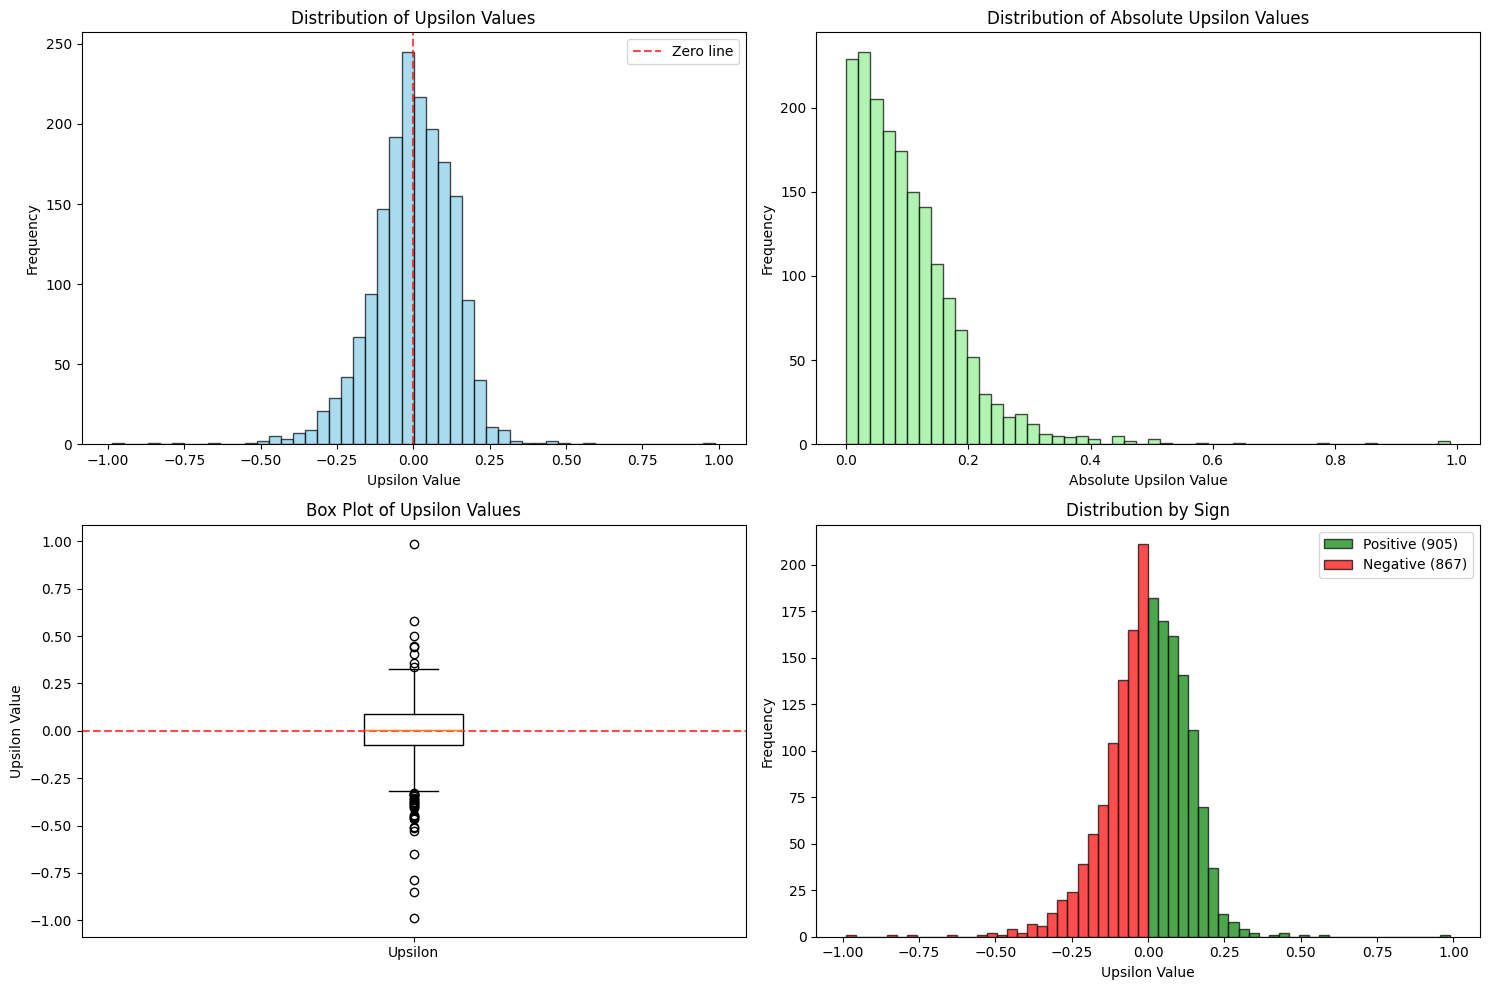

Summary Statistics for Upsilon Values:
Total pathways: 1772
Mean: -0.0021
Median: 0.0032
Standard deviation: 0.1362
Minimum: -0.9879
Maximum: 0.9885
Range: 1.9764

Positive upsilon values: 905 (51.1%)
Negative upsilon values: 867 (48.9%)
Zero upsilon values: 0

Percentiles:
5th percentile: -0.2273
10th percentile: -0.1656
25th percentile: -0.0765
50th percentile: 0.0032
75th percentile: 0.0875
90th percentile: 0.1522
95th percentile: 0.1873


In [16]:
# Create distribution plot of upsilon values
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram of all upsilon values
axes[0, 0].hist(pathway_upsilon_df['upsilon'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Upsilon Values')
axes[0, 0].set_xlabel('Upsilon Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero line')
axes[0, 0].legend()

# 2. Histogram of absolute upsilon values
axes[0, 1].hist(pathway_upsilon_df['abs_upsilon'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Absolute Upsilon Values')
axes[0, 1].set_xlabel('Absolute Upsilon Value')
axes[0, 1].set_ylabel('Frequency')

# 3. Box plot showing distribution
box_data = [pathway_upsilon_df['upsilon']]
axes[1, 0].boxplot(box_data, labels=['Upsilon'])
axes[1, 0].set_title('Box Plot of Upsilon Values')
axes[1, 0].set_ylabel('Upsilon Value')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 4. Separate histograms for positive and negative upsilon values
positive_upsilon = pathway_upsilon_df[pathway_upsilon_df['upsilon'] > 0]['upsilon']
negative_upsilon = pathway_upsilon_df[pathway_upsilon_df['upsilon'] < 0]['upsilon']

axes[1, 1].hist(positive_upsilon, bins=30, alpha=0.7, color='green', label=f'Positive ({len(positive_upsilon)})', edgecolor='black')
axes[1, 1].hist(negative_upsilon, bins=30, alpha=0.7, color='red', label=f'Negative ({len(negative_upsilon)})', edgecolor='black')
axes[1, 1].set_title('Distribution by Sign')
axes[1, 1].set_xlabel('Upsilon Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Upsilon Values:")
print("=" * 50)
print(f"Total pathways: {len(pathway_upsilon_df)}")
print(f"Mean: {pathway_upsilon_df['upsilon'].mean():.4f}")
print(f"Median: {pathway_upsilon_df['upsilon'].median():.4f}")
print(f"Standard deviation: {pathway_upsilon_df['upsilon'].std():.4f}")
print(f"Minimum: {pathway_upsilon_df['upsilon'].min():.4f}")
print(f"Maximum: {pathway_upsilon_df['upsilon'].max():.4f}")
print(f"Range: {pathway_upsilon_df['upsilon'].max() - pathway_upsilon_df['upsilon'].min():.4f}")
print(f"\nPositive upsilon values: {len(positive_upsilon)} ({len(positive_upsilon)/len(pathway_upsilon_df)*100:.1f}%)")
print(f"Negative upsilon values: {len(negative_upsilon)} ({len(negative_upsilon)/len(pathway_upsilon_df)*100:.1f}%)")
print(f"Zero upsilon values: {len(pathway_upsilon_df[pathway_upsilon_df['upsilon'] == 0])}")

# Percentiles
percentiles = [5, 10, 25, 50, 75, 90, 95]
print(f"\nPercentiles:")
for p in percentiles:
    value = np.percentile(pathway_upsilon_df['upsilon'], p)
    print(f"{p}th percentile: {value:.4f}")

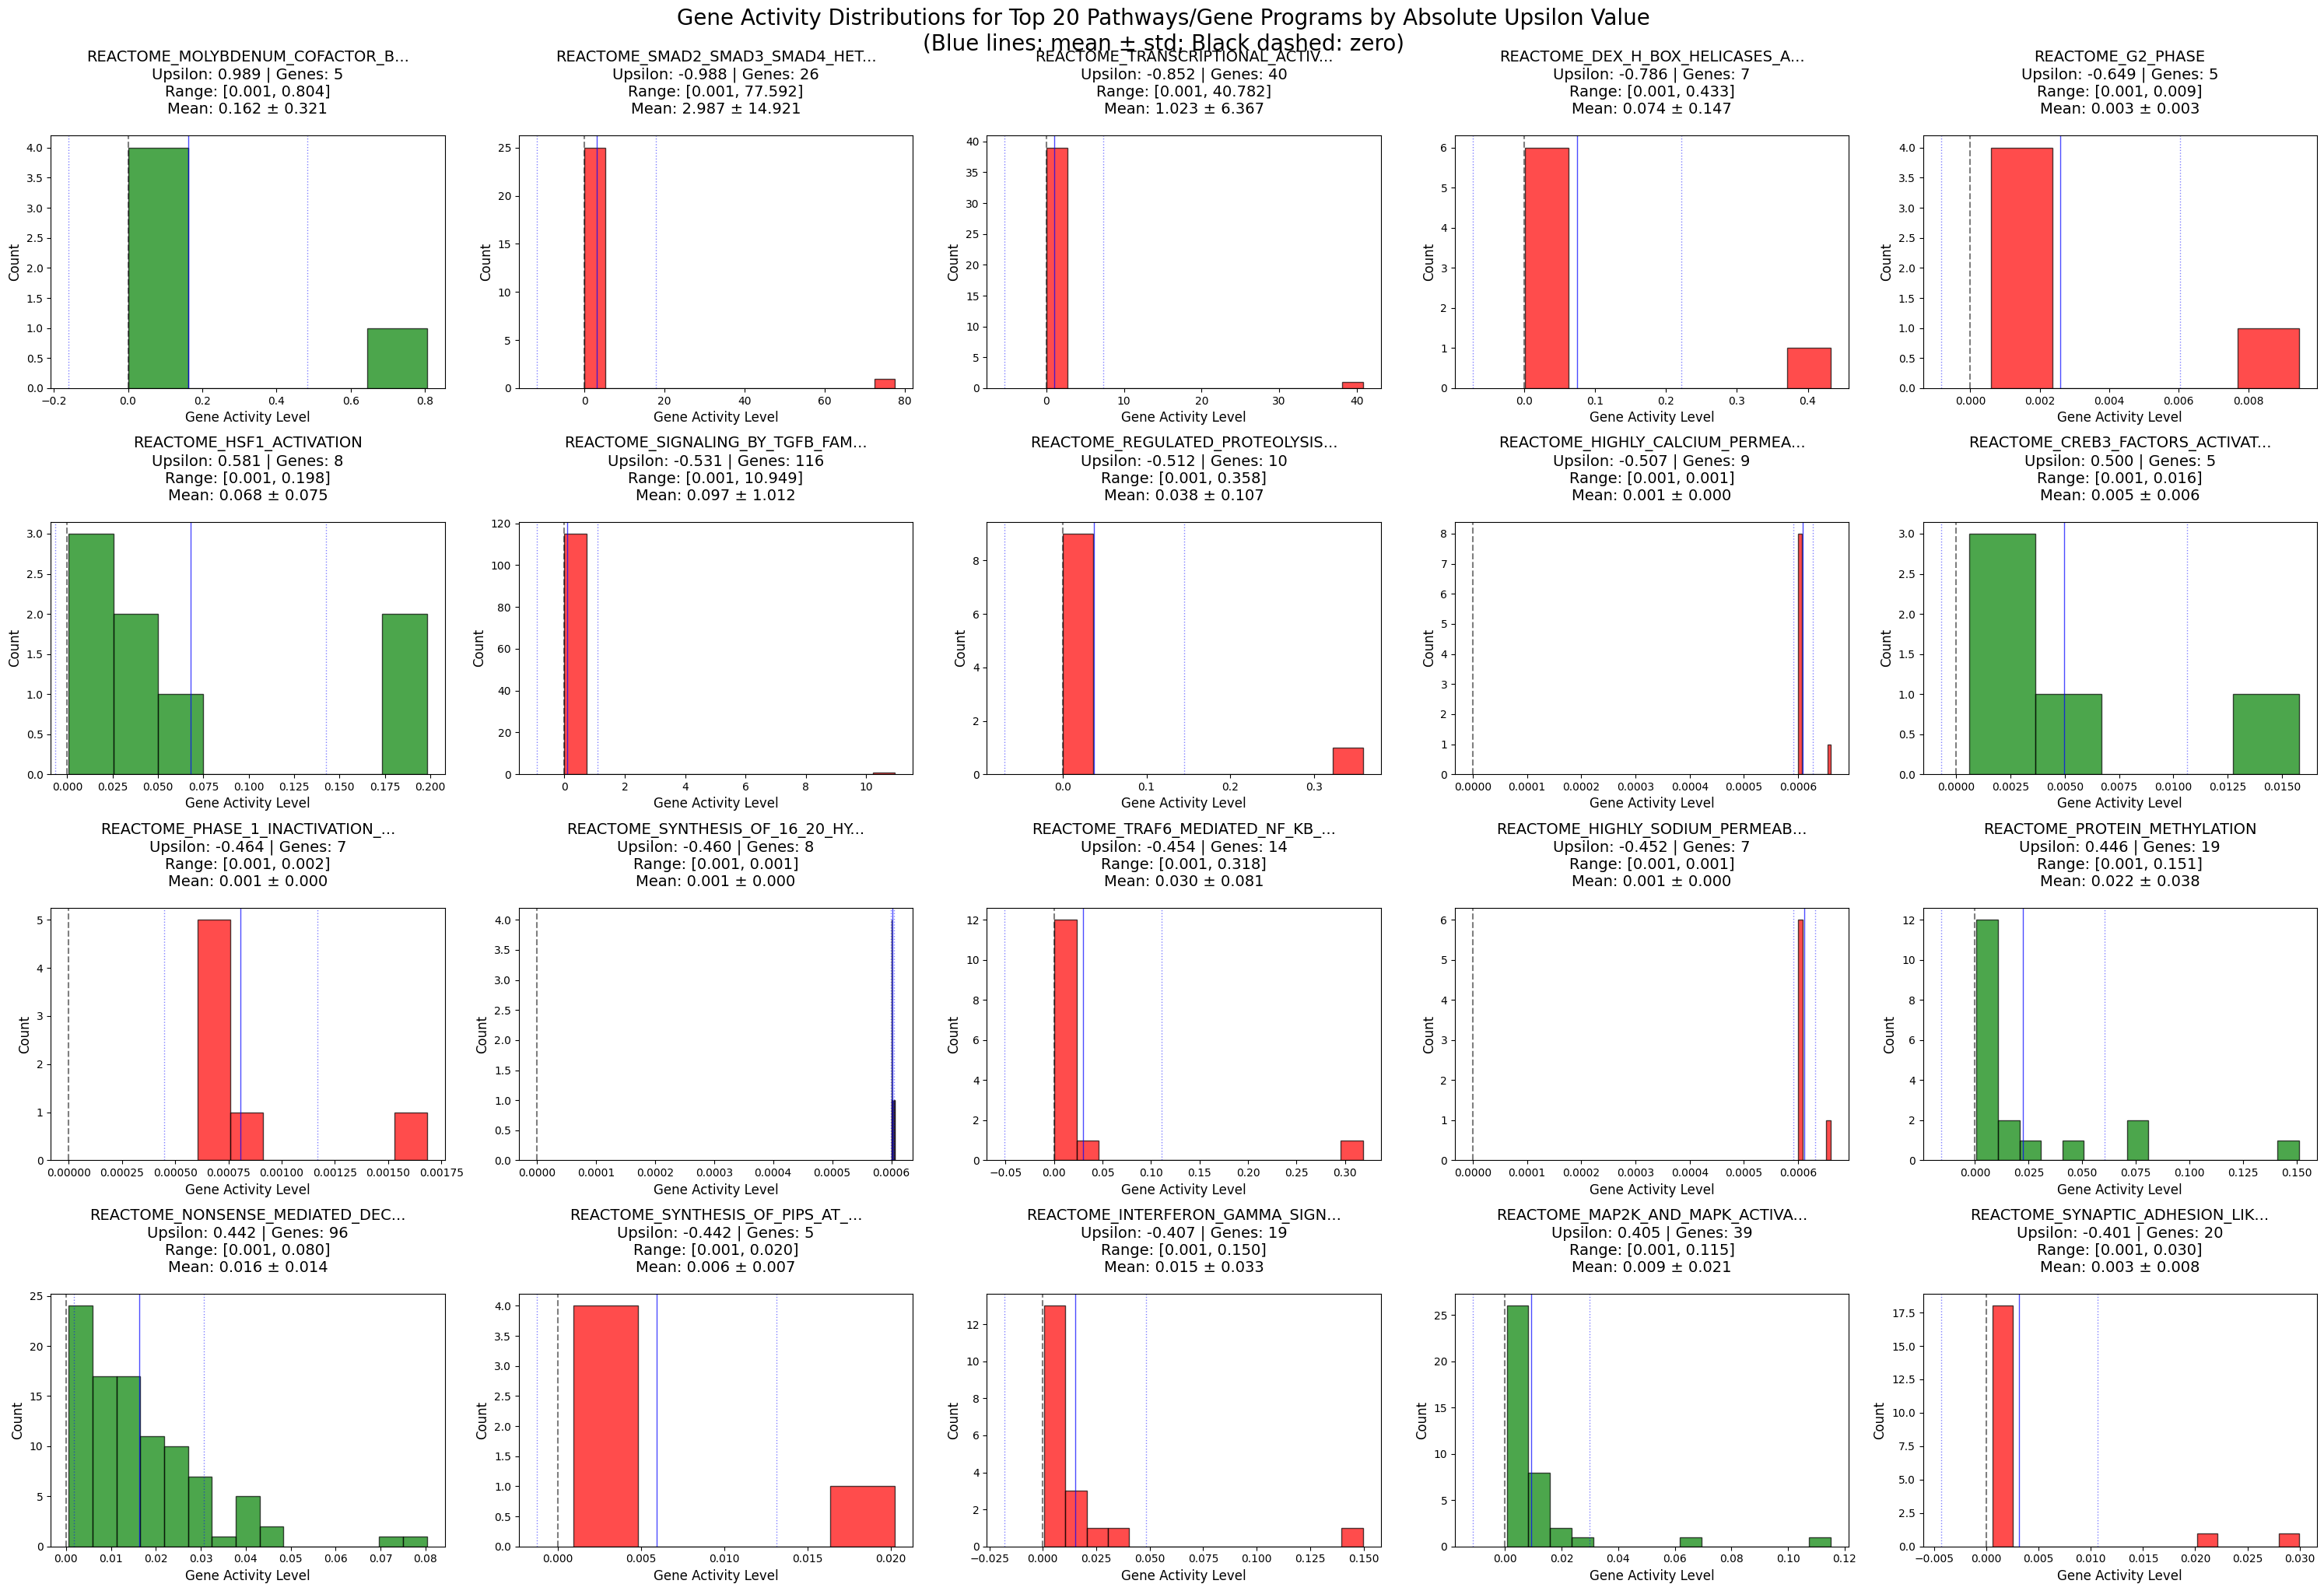

/tmp/ipykernel_27692/57005702.py:114: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



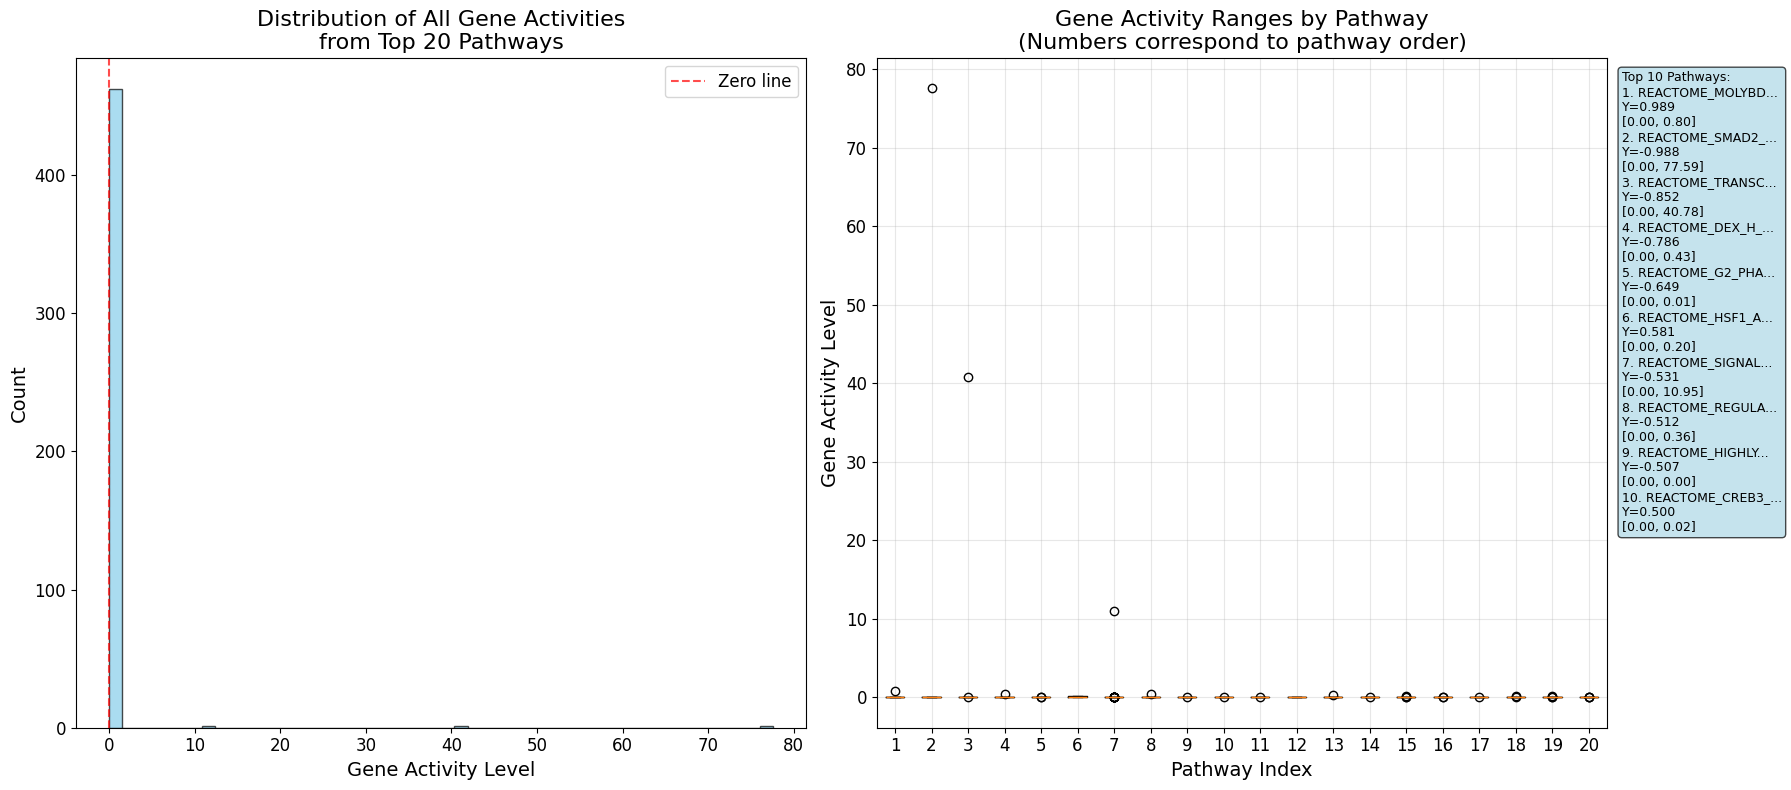

Summary Statistics for Gene Activities in Top 20 Pathways:

1. REACTOME_MOLYBDENUM_COFACTOR_BIOSYNTHESIS...
   Upsilon: 0.9885
   Number of genes: 5
   Activity range: 0.0006 to 0.8044
   Mean activity: 0.1617
   Std activity: 0.3213
   Positive activities: 5 (100.0%)
   Negative activities: 0 (0.0%)

2. REACTOME_SMAD2_SMAD3_SMAD4_HETEROTRIMER_REGULATES_TRANSCRIPT...
   Upsilon: -0.9879
   Number of genes: 26
   Activity range: 0.0006 to 77.5921
   Mean activity: 2.9873
   Std activity: 14.9210
   Positive activities: 26 (100.0%)
   Negative activities: 0 (0.0%)

3. REACTOME_TRANSCRIPTIONAL_ACTIVITY_OF_SMAD2_SMAD3_SMAD4_HETER...
   Upsilon: -0.8520
   Number of genes: 40
   Activity range: 0.0006 to 40.7823
   Mean activity: 1.0229
   Std activity: 6.3666
   Positive activities: 40 (100.0%)
   Negative activities: 0 (0.0%)

4. REACTOME_DEX_H_BOX_HELICASES_ACTIVATE_TYPE_I_IFN_AND_INFLAMM...
   Upsilon: -0.7858
   Number of genes: 7
   Activity range: 0.0007 to 0.4326
   Mean activity: 0

In [22]:
# Extract gene information and activity levels for top 20 pathways
top_20_pathways = pathway_upsilon_df_abs_sorted.head(20)

# Create a figure to show gene activity distributions for top 20 pathways
fig, axes = plt.subplots(4, 5, figsize=(30, 20))  # Increased width from 25 to 30, height from 16 to 20
axes = axes.flatten()

# Store gene activity data for summary statistics
all_gene_activities = []

for idx, (pathway_idx, row) in enumerate(top_20_pathways.iterrows()):
    pathway_name = row['pathway_name']
    upsilon_val = row['upsilon']
    
    # Get pathway information from best_pathways dataframe
    pathway_info = best_pathways.loc[pathway_name, 'pathways']
    genes_data = pathway_info['genes']
    
    # Extract gene activities (assuming 'activity' or similar field exists in genes data)
    gene_activities = []
    gene_names = []
    
    for gene in genes_data:
        if 'activity' in gene:
            gene_activities.append(gene['activity'])
            gene_names.append(gene.get('gene', 'Unknown'))
        elif 'weight' in gene:
            gene_activities.append(gene['weight'])
            gene_names.append(gene.get('gene', 'Unknown'))
        elif 'coefficient' in gene:
            gene_activities.append(gene['coefficient'])
            gene_names.append(gene.get('gene', 'Unknown'))
    
    # Store for summary
    all_gene_activities.extend(gene_activities)
    
    # Calculate statistics for this pathway
    gene_activities_array = np.array(gene_activities)
    activity_min = gene_activities_array.min()
    activity_max = gene_activities_array.max()
    activity_mean = gene_activities_array.mean()
    activity_std = gene_activities_array.std()
    
    # Plot histogram of gene activities for this pathway with linear scale
    axes[idx].hist(gene_activities, bins=min(15, len(gene_activities)), alpha=0.7, 
                   color='green' if upsilon_val > 0 else 'red', 
                   edgecolor='black')
    
    # Truncate pathway name for display
    display_name = pathway_name[:30] + '...' if len(pathway_name) > 30 else pathway_name
    
    # Create multi-line title with statistics
    title_text = f'{display_name}\nUpsilon: {upsilon_val:.3f} | Genes: {len(gene_activities)}\nRange: [{activity_min:.3f}, {activity_max:.3f}]\nMean: {activity_mean:.3f} ± {activity_std:.3f}'
    
    axes[idx].set_title(title_text, fontsize=14, pad=20)  # Increased from 10 to 14, pad from 15 to 20
    axes[idx].set_xlabel('Gene Activity Level', fontsize=12)  # Increased from 9 to 12
    axes[idx].set_ylabel('Count', fontsize=12)  # Increased from 9 to 12
    axes[idx].tick_params(labelsize=10)  # Increased from 8 to 10
    
    # Add vertical line at zero for reference
    axes[idx].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # Add vertical lines for mean and ±1 std
    axes[idx].axvline(x=activity_mean, color='blue', linestyle='-', alpha=0.7, linewidth=1)
    axes[idx].axvline(x=activity_mean + activity_std, color='blue', linestyle=':', alpha=0.5, linewidth=1)
    axes[idx].axvline(x=activity_mean - activity_std, color='blue', linestyle=':', alpha=0.5, linewidth=1)
    
    # Set reasonable y-axis limits
    axes[idx].set_ylim(bottom=0)

plt.tight_layout()
plt.suptitle('Gene Activity Distributions for Top 20 Pathways/Gene Programs by Absolute Upsilon Value\n(Blue lines: mean ± std; Black dashed: zero)', 
             fontsize=20, y=1.02)  # Increased from 16 to 20
plt.show()

# Create a summary plot showing the range of gene activities across all top 20 pathways
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  # Increased width from 15 to 18, height from 6 to 8

# Plot 1: Overall distribution of all gene activities
ax1.hist(all_gene_activities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of All Gene Activities\nfrom Top 20 Pathways', fontsize=16)  # Added fontsize
ax1.set_xlabel('Gene Activity Level', fontsize=14)  # Added fontsize
ax1.set_ylabel('Count', fontsize=14)  # Added fontsize
ax1.tick_params(labelsize=12)  # Added tick label size
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero line')
ax1.legend(fontsize=12)  # Added legend fontsize

# Plot 2: Box plot showing activity ranges per pathway with enhanced labels
pathway_activities = []
pathway_labels = []

for idx, (pathway_idx, row) in enumerate(top_20_pathways.iterrows()):
    pathway_name = row['pathway_name']
    pathway_info = best_pathways.loc[pathway_name, 'pathways']
    genes_data = pathway_info['genes']
    
    gene_activities = []
    for gene in genes_data:
        if 'activity' in gene:
            gene_activities.append(gene['activity'])
        elif 'weight' in gene:
            gene_activities.append(gene['weight'])
        elif 'coefficient' in gene:
            gene_activities.append(gene['coefficient'])
    
    if gene_activities:
        pathway_activities.append(gene_activities)
        # Create more informative labels with range info
        gene_arr = np.array(gene_activities)
        short_name = pathway_name[:15] + '...' if len(pathway_name) > 15 else pathway_name
        range_text = f'[{gene_arr.min():.2f}, {gene_arr.max():.2f}]'
        pathway_labels.append(f'{idx+1}. {short_name}\nΥ={row["upsilon"]:.3f}\n{range_text}')

bp = ax2.boxplot(pathway_activities, labels=range(1, len(pathway_activities)+1))
ax2.set_title('Gene Activity Ranges by Pathway\n(Numbers correspond to pathway order)', fontsize=16)  # Added fontsize
ax2.set_xlabel('Pathway Index', fontsize=14)  # Added fontsize
ax2.set_ylabel('Gene Activity Level', fontsize=14)  # Added fontsize
ax2.tick_params(axis='x', rotation=0, labelsize=12)  # Added tick label size
ax2.tick_params(axis='y', labelsize=12)  # Added tick label size
ax2.grid(True, alpha=0.3)

# Add a text box with pathway information
info_text = "\n".join(pathway_labels[:10])  # Show first 10 pathways
ax2.text(1.02, 0.98, f"Top 10 Pathways:\n{info_text}", transform=ax2.transAxes, 
         fontsize=9, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))  # Increased from 6 to 9

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Gene Activities in Top 20 Pathways:")
print("=" * 70)

for idx, (pathway_idx, row) in enumerate(top_20_pathways.iterrows()):
    pathway_name = row['pathway_name']
    upsilon_val = row['upsilon']
    
    pathway_info = best_pathways.loc[pathway_name, 'pathways']
    genes_data = pathway_info['genes']
    
    gene_activities = []
    for gene in genes_data:
        if 'activity' in gene:
            gene_activities.append(gene['activity'])
        elif 'weight' in gene:
            gene_activities.append(gene['weight'])
        elif 'coefficient' in gene:
            gene_activities.append(gene['coefficient'])
    
    if gene_activities:
        gene_activities = np.array(gene_activities)
        print(f"\n{idx+1}. {pathway_name[:60]}...")
        print(f"   Upsilon: {upsilon_val:.4f}")
        print(f"   Number of genes: {len(gene_activities)}")
        print(f"   Activity range: {gene_activities.min():.4f} to {gene_activities.max():.4f}")
        print(f"   Mean activity: {gene_activities.mean():.4f}")
        print(f"   Std activity: {gene_activities.std():.4f}")
        print(f"   Positive activities: {(gene_activities > 0).sum()} ({(gene_activities > 0).mean()*100:.1f}%)")
        print(f"   Negative activities: {(gene_activities < 0).sum()} ({(gene_activities < 0).mean()*100:.1f}%)")

# Overall statistics
all_activities = np.array(all_gene_activities)
print(f"\nOverall Statistics for All Gene Activities:")
print(f"Total genes across top 20 pathways: {len(all_activities)}")
print(f"Overall range: {all_activities.min():.6f} to {all_activities.max():.6f}")
print(f"Overall mean: {all_activities.mean():.6f}")
print(f"Overall median: {np.median(all_activities):.6f}")
print(f"Overall std: {all_activities.std():.6f}")

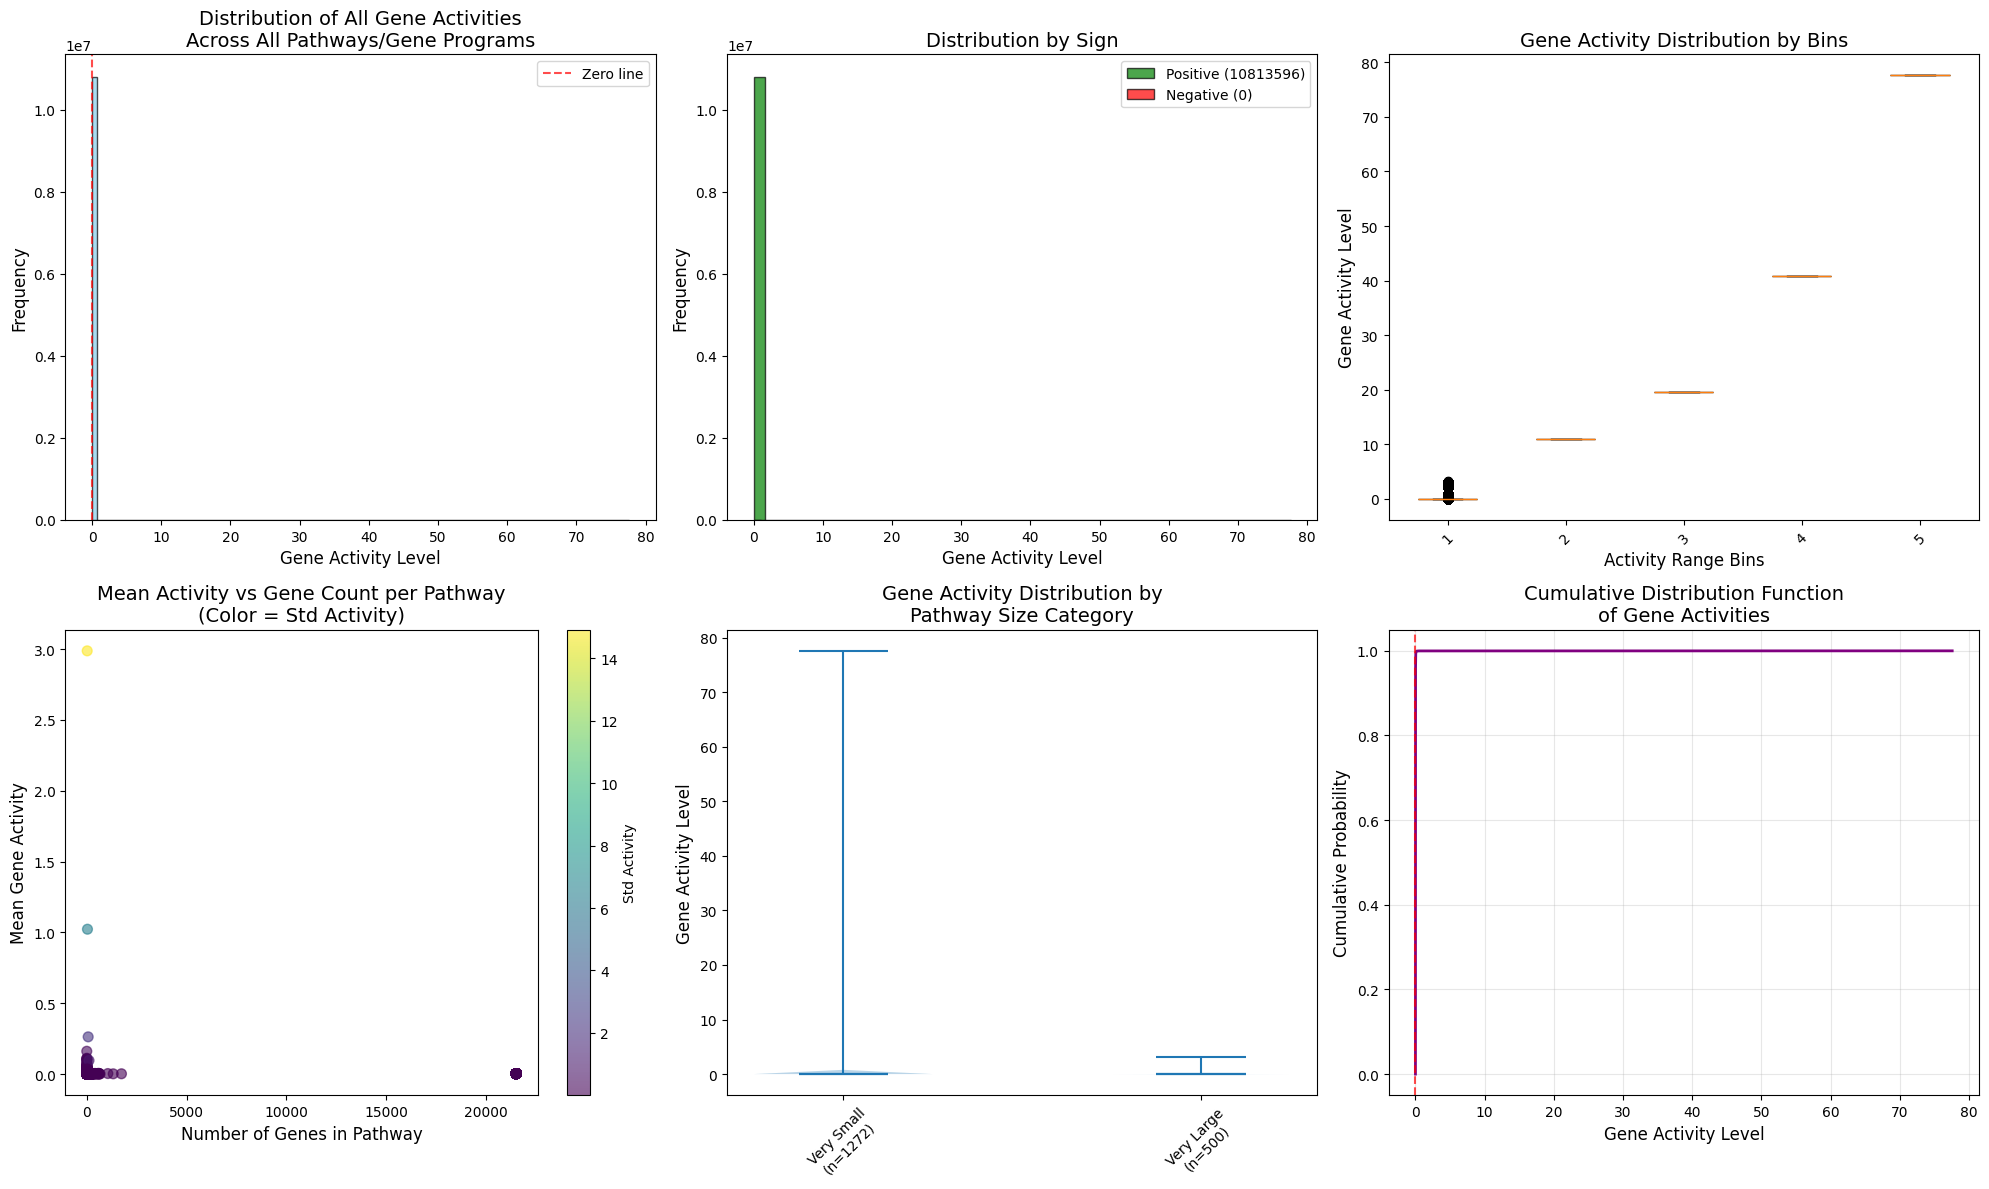

=== COMPREHENSIVE GENE ACTIVITY ANALYSIS ===
Total number of genes across all pathways: 10,813,596
Total number of pathways/gene programs: 1,772

Overall Gene Activity Statistics:
----------------------------------------
Mean: 0.003559
Median: 0.000656
Standard deviation: 0.043592
Minimum: 0.000600
Maximum: 77.592082
Range: 77.591482

Activity Distribution by Sign:
------------------------------
Positive activities: 10,813,596 (100.0%)
Negative activities: 0 (0.0%)
Zero activities: 0 (0.0%)

Percentiles:
---------------
 1th percentile: 0.000600
 5th percentile: 0.000600
10th percentile: 0.000600
25th percentile: 0.000602
50th percentile: 0.000656
75th percentile: 0.001470
90th percentile: 0.005999
95th percentile: 0.013406
99th percentile: 0.041013

Pathway-Level Statistics:
-------------------------
Average genes per pathway: 6102.5
Median genes per pathway: 39.0
Min genes per pathway: 4
Max genes per pathway: 21501

Extreme Values:
---------------
Top 10 Highest Gene Activities:
 1.

In [23]:
# Get all gene activity data from all pathways/gene programs
all_gene_data = []
pathway_gene_counts = []

for pathway_idx, pathway_row in best_pathways.iterrows():
    pathway_name = pathway_idx
    pathway_info = pathway_row['pathways']
    genes_data = pathway_info['genes']
    
    # Extract gene activities for this pathway
    pathway_activities = []
    for gene in genes_data:
        if 'activity' in gene:
            activity = gene['activity']
            all_gene_data.append({
                'pathway': pathway_name,
                'gene': gene.get('gene', 'Unknown'),
                'activity': activity
            })
            pathway_activities.append(activity)
        elif 'weight' in gene:
            activity = gene['weight']
            all_gene_data.append({
                'pathway': pathway_name,
                'gene': gene.get('gene', 'Unknown'),
                'activity': activity
            })
            pathway_activities.append(activity)
        elif 'coefficient' in gene:
            activity = gene['coefficient']
            all_gene_data.append({
                'pathway': pathway_name,
                'gene': gene.get('gene', 'Unknown'),
                'activity': activity
            })
            pathway_activities.append(activity)
    
    # Store pathway-level statistics
    if pathway_activities:
        pathway_gene_counts.append({
            'pathway': pathway_name,
            'gene_count': len(pathway_activities),
            'mean_activity': np.mean(pathway_activities),
            'std_activity': np.std(pathway_activities),
            'min_activity': np.min(pathway_activities),
            'max_activity': np.max(pathway_activities)
        })

# Convert to DataFrames
all_genes_df = pd.DataFrame(all_gene_data)
pathway_stats_df = pd.DataFrame(pathway_gene_counts)

# Create comprehensive visualization of gene activity distributions
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Overall distribution of all gene activities
axes[0, 0].hist(all_genes_df['activity'], bins=100, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of All Gene Activities\nAcross All Pathways/Gene Programs', fontsize=14)
axes[0, 0].set_xlabel('Gene Activity Level', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero line')
axes[0, 0].legend()

# 2. Log-scale histogram for better visibility of distribution tails
positive_activities = all_genes_df[all_genes_df['activity'] > 0]['activity']
negative_activities = all_genes_df[all_genes_df['activity'] < 0]['activity']
zero_activities = all_genes_df[all_genes_df['activity'] == 0]['activity']

axes[0, 1].hist(positive_activities, bins=50, alpha=0.7, color='green', label=f'Positive ({len(positive_activities)})', edgecolor='black')
axes[0, 1].hist(negative_activities, bins=50, alpha=0.7, color='red', label=f'Negative ({len(negative_activities)})', edgecolor='black')
axes[0, 1].set_title('Distribution by Sign', fontsize=14)
axes[0, 1].set_xlabel('Gene Activity Level', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].legend()

# 3. Box plot of gene activities by activity range bins
activity_ranges = pd.cut(all_genes_df['activity'], bins=20, labels=False)
unique_ranges = sorted(activity_ranges.dropna().unique())
boxplot_data = [all_genes_df[activity_ranges == r]['activity'].values for r in unique_ranges if len(all_genes_df[activity_ranges == r]) > 0]

if boxplot_data:
    bp = axes[0, 2].boxplot(boxplot_data, patch_artist=True)
    axes[0, 2].set_title('Gene Activity Distribution by Bins', fontsize=14)
    axes[0, 2].set_xlabel('Activity Range Bins', fontsize=12)
    axes[0, 2].set_ylabel('Gene Activity Level', fontsize=12)
    axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Distribution of pathway-level statistics
axes[1, 0].scatter(pathway_stats_df['gene_count'], pathway_stats_df['mean_activity'], 
                   alpha=0.6, s=50, c=pathway_stats_df['std_activity'], cmap='viridis')
axes[1, 0].set_title('Mean Activity vs Gene Count per Pathway\n(Color = Std Activity)', fontsize=14)
axes[1, 0].set_xlabel('Number of Genes in Pathway', fontsize=12)
axes[1, 0].set_ylabel('Mean Gene Activity', fontsize=12)
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Std Activity', fontsize=10)

# 5. Violin plot of activities for pathways with different gene counts
gene_count_bins = pd.cut(pathway_stats_df['gene_count'], bins=5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
violin_data = []
labels = []
for bin_label in gene_count_bins.cat.categories:
    pathways_in_bin = pathway_stats_df[gene_count_bins == bin_label]['pathway']
    activities_in_bin = all_genes_df[all_genes_df['pathway'].isin(pathways_in_bin)]['activity']
    if len(activities_in_bin) > 0:
        violin_data.append(activities_in_bin.values)
        labels.append(f'{bin_label}\n(n={len(pathways_in_bin)})')

if violin_data:
    parts = axes[1, 1].violinplot(violin_data, positions=range(len(violin_data)), showmeans=True, showmedians=True)
    axes[1, 1].set_xticks(range(len(labels)))
    axes[1, 1].set_xticklabels(labels, rotation=45)
    axes[1, 1].set_title('Gene Activity Distribution by\nPathway Size Category', fontsize=14)
    axes[1, 1].set_ylabel('Gene Activity Level', fontsize=12)

# 6. Cumulative distribution function
sorted_activities = np.sort(all_genes_df['activity'])
cumulative_prob = np.arange(1, len(sorted_activities) + 1) / len(sorted_activities)
axes[1, 2].plot(sorted_activities, cumulative_prob, linewidth=2, color='purple')
axes[1, 2].set_title('Cumulative Distribution Function\nof Gene Activities', fontsize=14)
axes[1, 2].set_xlabel('Gene Activity Level', fontsize=12)
axes[1, 2].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print comprehensive summary statistics
print("=== COMPREHENSIVE GENE ACTIVITY ANALYSIS ===")
print(f"Total number of genes across all pathways: {len(all_genes_df):,}")
print(f"Total number of pathways/gene programs: {len(pathway_stats_df):,}")
print()

print("Overall Gene Activity Statistics:")
print("-" * 40)
activities = all_genes_df['activity'].values
print(f"Mean: {np.mean(activities):.6f}")
print(f"Median: {np.median(activities):.6f}")
print(f"Standard deviation: {np.std(activities):.6f}")
print(f"Minimum: {np.min(activities):.6f}")
print(f"Maximum: {np.max(activities):.6f}")
print(f"Range: {np.max(activities) - np.min(activities):.6f}")
print()

print("Activity Distribution by Sign:")
print("-" * 30)
print(f"Positive activities: {len(positive_activities):,} ({len(positive_activities)/len(activities)*100:.1f}%)")
print(f"Negative activities: {len(negative_activities):,} ({len(negative_activities)/len(activities)*100:.1f}%)")
print(f"Zero activities: {len(zero_activities):,} ({len(zero_activities)/len(activities)*100:.1f}%)")
print()

print("Percentiles:")
print("-" * 15)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(activities, p)
    print(f"{p:2d}th percentile: {value:.6f}")
print()

print("Pathway-Level Statistics:")
print("-" * 25)
print(f"Average genes per pathway: {pathway_stats_df['gene_count'].mean():.1f}")
print(f"Median genes per pathway: {pathway_stats_df['gene_count'].median():.1f}")
print(f"Min genes per pathway: {pathway_stats_df['gene_count'].min()}")
print(f"Max genes per pathway: {pathway_stats_df['gene_count'].max()}")
print()

print("Extreme Values:")
print("-" * 15)
# Top 10 highest and lowest activities
sorted_genes = all_genes_df.sort_values('activity', ascending=False)
print("Top 10 Highest Gene Activities:")
for i, (_, row) in enumerate(sorted_genes.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['gene'][:30]:30} | {row['activity']:.6f} | {row['pathway'][:40]}")

print("\nTop 10 Lowest Gene Activities:")
for i, (_, row) in enumerate(sorted_genes.tail(10).iterrows(), 1):
    print(f"{i:2d}. {row['gene'][:30]:30} | {row['activity']:.6f} | {row['pathway'][:40]}")

In [ ]:
import mygene

# Initialize mygene query
mg = mygene.MyGeneInfo()

# Get top 10 highest and lowest activity genes
top_10_highest = sorted_genes.head(10)
top_10_lowest = sorted_genes.tail(10)

def get_gene_symbols(gene_ids):
    """Convert Ensembl IDs to gene symbols using mygene"""
    # Query mygene for gene symbols
    results = mg.querymany(gene_ids, scopes='ensembl.gene', fields='symbol', species='mouse')
    
    # Create a mapping dictionary
    id_to_symbol = {}
    for result in results:
        if 'symbol' in result:
            id_to_symbol[result['query']] = result['symbol']
        else:
            id_to_symbol[result['query']] = result['query']  # Keep original if no symbol found
    
    return id_to_symbol

# Get gene symbols for highest activity genes
highest_gene_ids = top_10_highest['gene'].tolist()
highest_symbols = get_gene_symbols(highest_gene_ids)

# Get gene symbols for lowest activity genes  
lowest_gene_ids = top_10_lowest['gene'].tolist()
lowest_symbols = get_gene_symbols(lowest_gene_ids)

print("=" * 100)
print("TOP 10 HIGHEST ACTIVITY GENES")
print("=" * 100)
print(f"{'Rank':<4} {'Ensembl ID':<20} {'Gene Symbol':<15} {'Activity':<12} {'Pathway':<50}")
print("-" * 100)

for i, (_, row) in enumerate(top_10_highest.iterrows(), 1):
    ensembl_id = row['gene']
    symbol = highest_symbols.get(ensembl_id, 'Unknown')
    activity = row['activity']
    pathway = row['pathway'][:47] + '...' if len(row['pathway']) > 50 else row['pathway']
    
    print(f"{i:<4} {ensembl_id:<20} {symbol:<15} {activity:<12.6f} {pathway:<50}")

print("\n" + "=" * 100)
print("TOP 10 LOWEST ACTIVITY GENES")
print("=" * 100)
print(f"{'Rank':<4} {'Ensembl ID':<20} {'Gene Symbol':<15} {'Activity':<12} {'Pathway':<50}")
print("-" * 100)

for i, (_, row) in enumerate(top_10_lowest.iterrows(), 1):
    ensembl_id = row['gene']
    symbol = lowest_symbols.get(ensembl_id, 'Unknown')
    activity = row['activity']
    pathway = row['pathway'][:47] + '...' if len(row['pathway']) > 50 else row['pathway']
    
    print(f"{i:<4} {ensembl_id:<20} {symbol:<15} {activity:<12.6f} {pathway:<50}")

# Additional summary
print(f"\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Highest activity gene: {highest_symbols.get(top_10_highest.iloc[0]['gene'], 'Unknown')} ({top_10_highest.iloc[0]['gene']})")
print(f"  Activity: {top_10_highest.iloc[0]['activity']:.6f}")
print(f"  Pathway: {top_10_highest.iloc[0]['pathway']}")

print(f"\nLowest activity gene: {lowest_symbols.get(top_10_lowest.iloc[-1]['gene'], 'Unknown')} ({top_10_lowest.iloc[-1]['gene']})")
print(f"  Activity: {top_10_lowest.iloc[-1]['activity']:.6f}")
print(f"  Pathway: {top_10_lowest.iloc[-1]['pathway']}")

print(f"\nActivity range: {top_10_lowest.iloc[-1]['activity']:.6f} to {top_10_highest.iloc[0]['activity']:.6f}")
print(f"Fold difference: {top_10_highest.iloc[0]['activity'] / top_10_lowest.iloc[-1]['activity']:.1f}x")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found dup hits:	[('ENSMUSG00000029635', 4), ('ENSMUSG00000035202', 6)]
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


TOP 10 HIGHEST ACTIVITY GENES
Rank Ensembl ID           Gene Symbol     Activity     Pathway                                           
----------------------------------------------------------------------------------------------------
1    ENSMUSG00000029635   Cdk8            77.592082    REACTOME_SMAD2_SMAD3_SMAD4_HETEROTRIMER_REGULAT...
2    ENSMUSG00000029635   Cdk8            40.782323    REACTOME_TRANSCRIPTIONAL_ACTIVITY_OF_SMAD2_SMAD...
3    ENSMUSG00000029635   Cdk8            19.525448    REACTOME_SIGNALING_BY_TGF_BETA_RECEPTOR_COMPLEX   
4    ENSMUSG00000029635   Cdk8            10.949211    REACTOME_SIGNALING_BY_TGFB_FAMILY_MEMBERS         
5    ENSMUSG00000035202   Lars2           3.160206     gene_program_51                                   
6    ENSMUSG00000035202   Lars2           3.158021     gene_program_189                                  
7    ENSMUSG00000035202   Lars2           3.138794     gene_program_101                                  
8    ENSMUSG000000352

: 